In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
np.random.seed(42)

%matplotlib inline

Not fully done yet

### TODO:
- interpret the values
- try different feature engineering, education might not need one-hot encoding as it might be considered ordinal. HeightX might need normalizing and better understanding, as those are integer and not fully clear to me.

Yet another R run was needed

```
library(foreign)
write.csv(read.dta("./ARM_Data/earnings/heights.dta"), "./ARM_Data/earnings/heights.csv", row.names=FALSE)
```

In [2]:
earnings_df = pd.read_csv("./ARM_Data/earnings/heights.csv")

In [3]:
earnings_df.describe()

,earn,height1,height2,sex,race,hisp,ed,yearbn,height
count,1379.000000,2021.000000,2023.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2021.000000
mean,20014.858593,5.122217,5.186357,1.631345,1.187284,1.952686,13.307048,46.980286,66.561108
std,19763.754808,0.357946,4.349514,0.482559,0.675301,0.316740,3.726320,17.894844,3.819420
min,0.000000,4.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,57.000000
25%,6000.000000,5.000000,3.000000,1.000000,1.000000,2.000000,12.000000,34.000000,64.000000
50%,16400.000000,5.000000,5.000000,2.000000,1.000000,2.000000,12.000000,50.000000,66.000000
75%,28000.000000,5.000000,8.000000,2.000000,1.000000,2.000000,15.000000,60.000000,69.000000
max,200000.000000,6.000000,98.000000,2.000000,9.000000,9.000000,99.000000,99.000000,82.000000


Some transformations needed:
* `ed` and `yearbn` seem to have some nonsensical values of 99. Those need to be removed.
* `earn` seems to have grow slowly in the early percentiles and very fast beyong median, so the additivity of the model we build might be under a question. Log transformation is better to be added.
* `sex` field needs to be centered
* `hisp`, `ed`, and `race` need to be factorized


In [4]:
earnings_df.head()

,earn,height1,height2,sex,race,hisp,ed,yearbn,height
0,NaN,5.0,6.0,2,1,2,12,53,66.0
1,NaN,5.0,4.0,1,2,2,12,50,64.0
2,50000.0,6.0,2.0,1,1,2,16,45,74.0
3,60000.0,5.0,6.0,2,1,2,16,32,66.0
4,30000.0,5.0,4.0,2,1,2,16,61,64.0


Some earnings are missing. Let's try those later as a test set for a model. For now we focus on the data with no missing values.

In [5]:
earn_eps = earnings_df.query("earn > 0").earn.min() / 2
earnings_df_clean = earnings_df[
    (~earnings_df.isna().any(axis="columns")) &
    (earnings_df.yearbn != 99) & 
    (earnings_df.ed < 98)
].assign(
    earn=lambda x: np.log(x.earn + earn_eps),
    sex=lambda x: x.sex - (x.sex.max() + x.sex.min()) / 2,
    ed_labels=lambda x: pd.cut(x.ed, [0,4,10,13,20], include_lowest=True, right=False, labels=['elementary', 'middle', 'high', 'grad'])
)

earnings_df_concat = pd.concat([
    earnings_df_clean,
    pd.get_dummies(earnings_df_clean.hisp, prefix="hisp", drop_first=True),
    pd.get_dummies(earnings_df_clean.ed_labels, prefix="ed", drop_first=True),
    pd.get_dummies(earnings_df_clean.race, prefix="race", drop_first=True)
], axis="columns").drop(columns=["race", "hisp", "ed", "ed_labels"])


In [6]:
earnings_df_concat

,earn,height1,height2,sex,yearbn,height,hisp_2,ed_middle,ed_high,ed_grad,race_2,race_3,race_4,race_9
2,10.821776,6.0,2.0,-0.5,45,74.0,1,0,0,1,0,0,0,0
3,11.003765,5.0,6.0,0.5,32,66.0,1,0,0,1,0,0,0,0
4,10.312280,5.0,4.0,0.5,61,64.0,1,0,0,1,0,0,0,0
8,10.841540,5.0,3.0,0.5,51,63.0,1,0,0,1,0,0,0,0
9,9.116030,5.0,4.0,0.5,64,64.0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,9.857444,6.0,0.0,-0.5,61,72.0,1,0,1,0,0,0,0,0
2024,9.622450,5.0,1.0,0.5,8,61.0,1,0,0,1,0,0,0,0
2025,8.999619,5.0,4.0,0.5,57,64.0,1,0,1,0,0,0,0,0
2026,11.003765,6.0,0.0,-0.5,40,72.0,1,0,1,0,0,0,0,0


In [7]:
earnings_df_concat.describe().T

,count,mean,std,min,25%,50%,75%,max
earn,1376.0,9.028038,1.945604,4.60517,8.716044,9.687815,10.243525,12.206573
height1,1376.0,5.128634,0.360032,4.00000,5.000000,5.000000,5.000000,6.000000
height2,1376.0,5.047965,3.174768,0.00000,3.000000,5.000000,8.000000,11.000000
sex,1376.0,0.122820,0.484857,-0.50000,-0.500000,0.500000,0.500000,0.500000
yearbn,1376.0,48.779797,15.635351,1.00000,39.000000,52.000000,61.000000,72.000000
height,1376.0,66.591570,3.804730,58.00000,64.000000,66.000000,69.000000,77.000000
hisp_2,1376.0,0.941860,0.234092,0.00000,1.000000,1.000000,1.000000,1.000000
ed_middle,1376.0,0.049419,0.216819,0.00000,0.000000,0.000000,0.000000,1.000000
ed_high,1376.0,0.431686,0.495491,0.00000,0.000000,0.000000,1.000000,1.000000
ed_grad,1376.0,0.518169,0.499851,0.00000,0.000000,1.000000,1.000000,1.000000


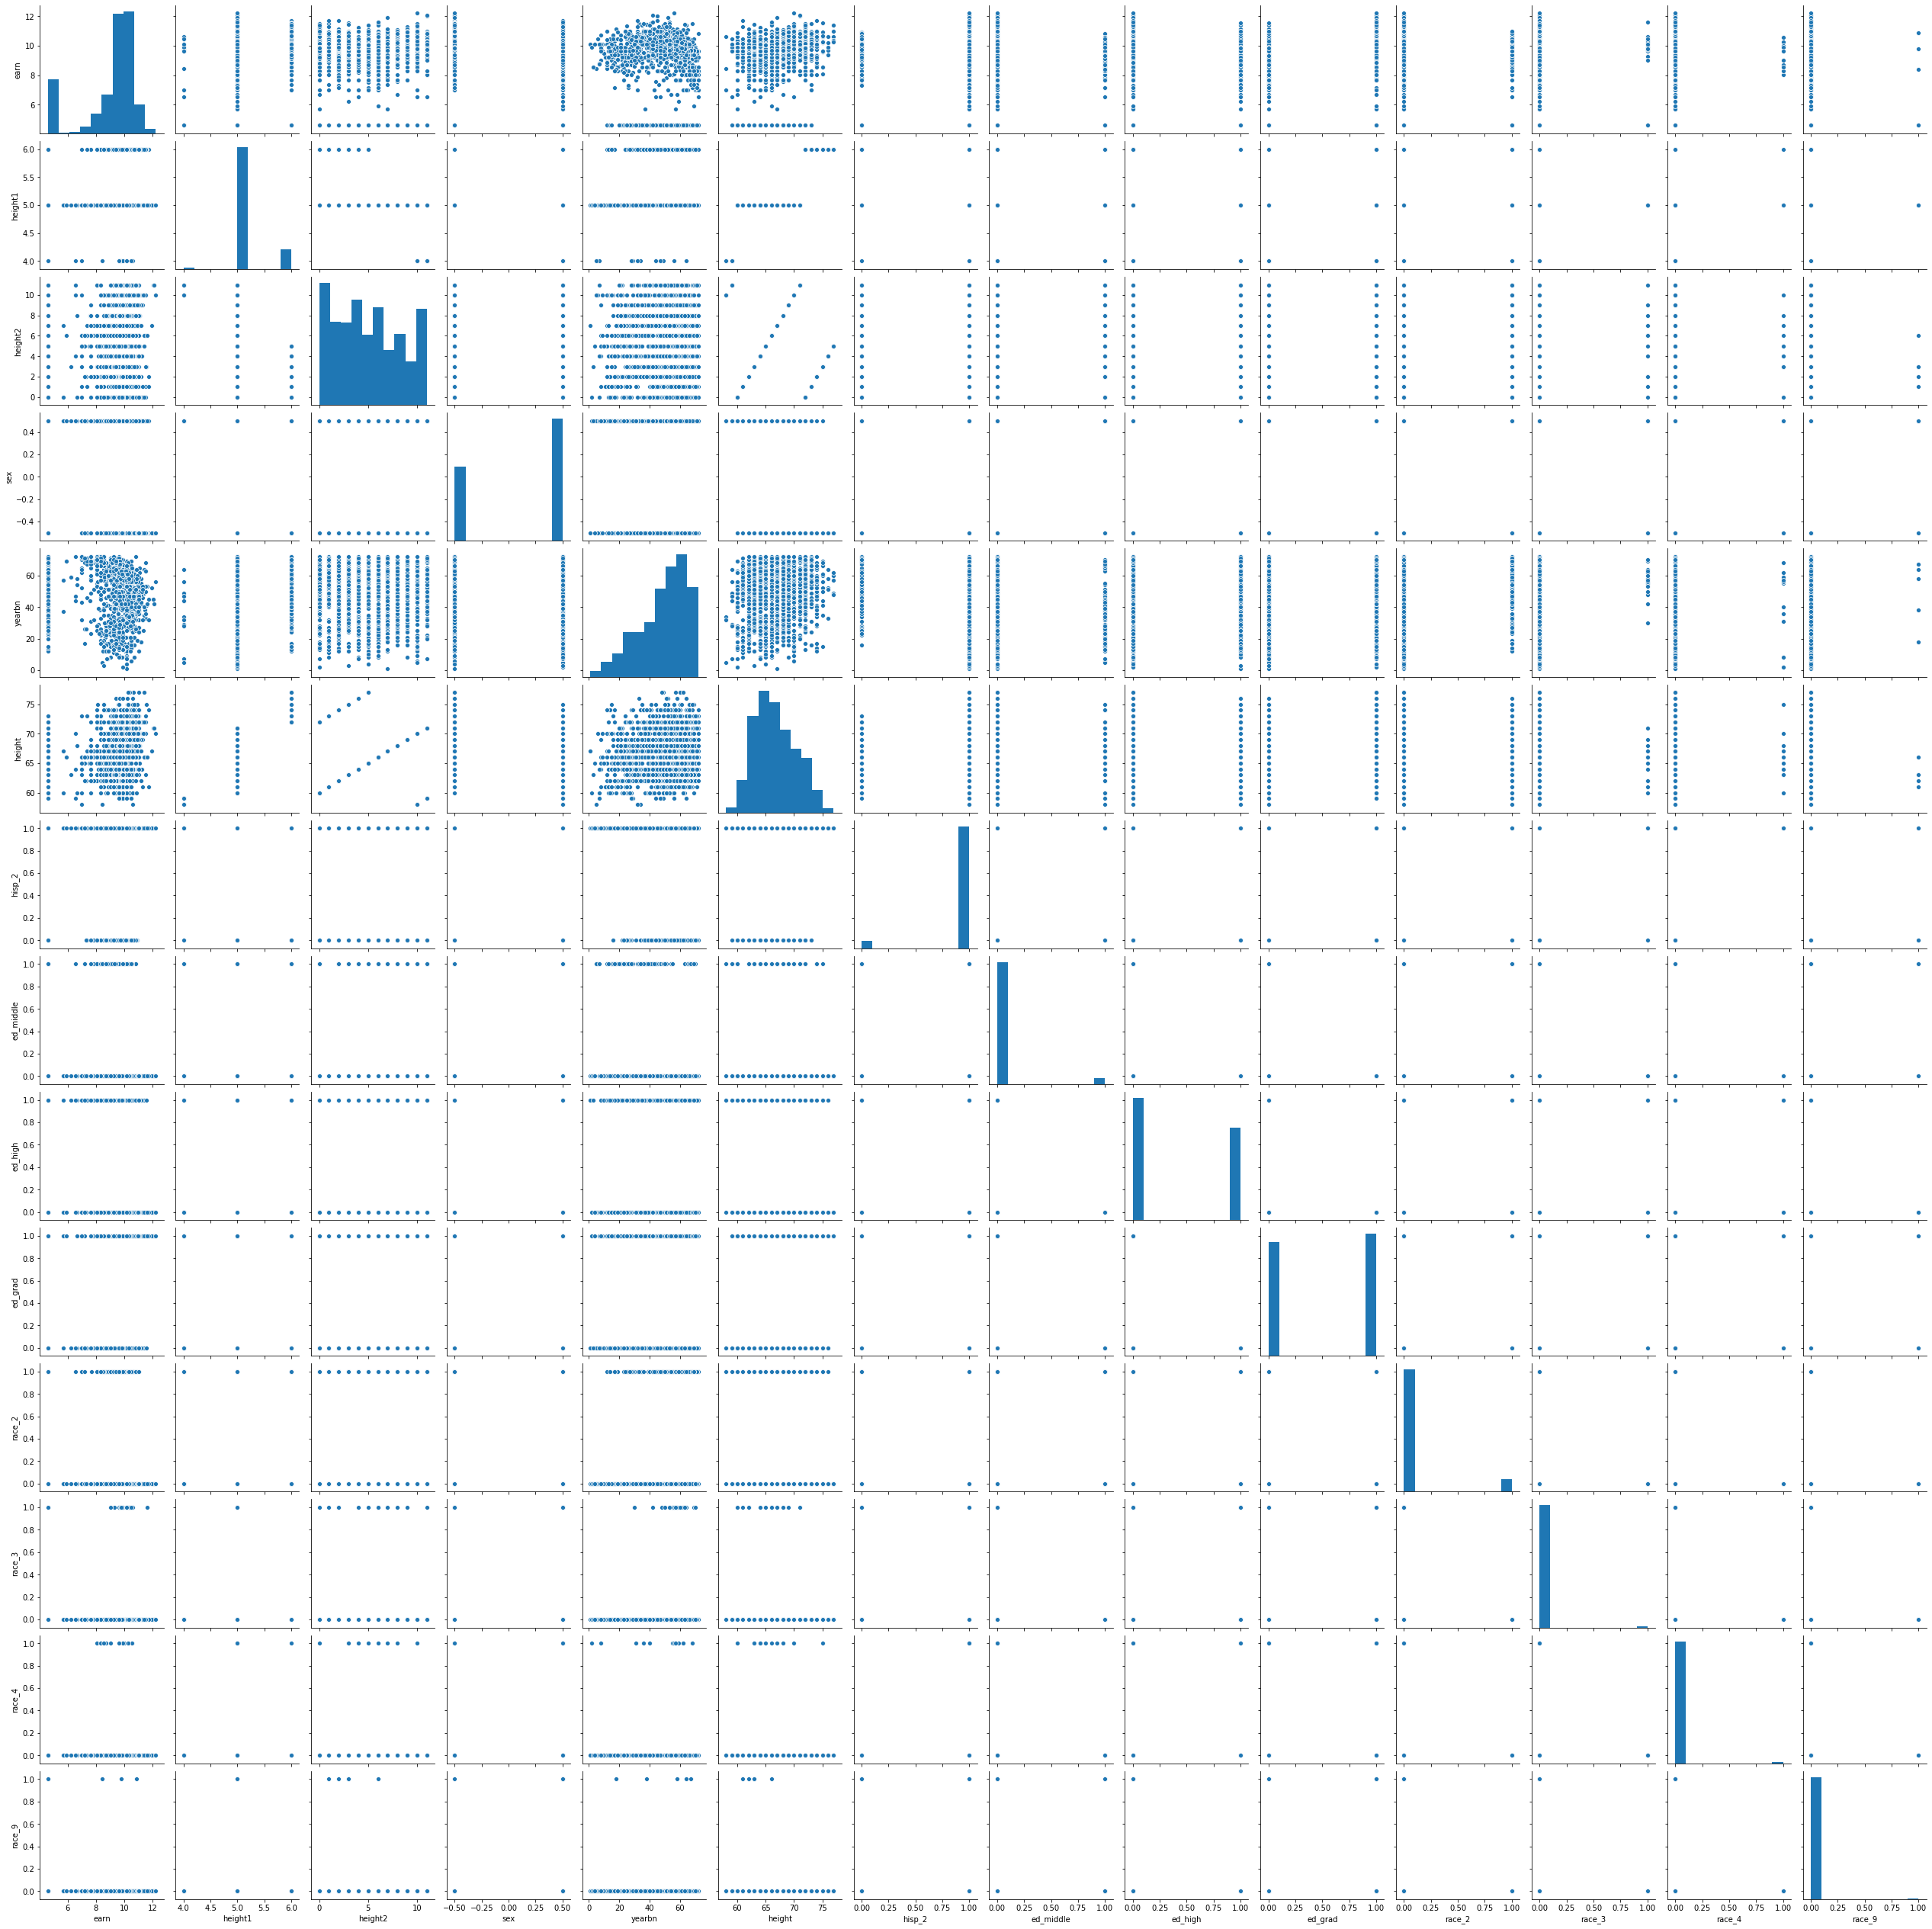

In [8]:
sns.pairplot(earnings_df_concat)

In [9]:
cmap=sns.diverging_palette(5, 250, as_cmap=True)
earnings_df_concat.corr().style.background_gradient(cmap)

,earn,height1,height2,sex,yearbn,height,hisp_2,ed_middle,ed_high,ed_grad,race_2,race_3,race_4,race_9
earn,1.000000,0.165612,0.128235,-0.338068,-0.045210,0.295061,0.031208,-0.129679,-0.175708,0.231709,0.006595,0.002931,0.015043,-0.042421
height1,0.165612,1.000000,-0.520147,-0.488444,0.116273,0.701505,0.002508,-0.044227,-0.026126,0.045602,0.005546,-0.039975,-0.009410,-0.021584
height2,0.128235,-0.520147,1.000000,-0.181005,0.001517,0.243784,0.076170,0.017685,-0.045998,0.039322,-0.015120,0.004529,-0.006500,-0.038970
sex,-0.338068,-0.488444,-0.181005,1.000000,-0.070252,-0.705679,0.011698,0.004485,0.033436,-0.036222,0.007927,-0.048703,0.019346,0.022076
yearbn,-0.045210,0.116273,0.001517,-0.070252,1.000000,0.133297,-0.063310,-0.187721,0.008242,0.075377,0.031880,0.048721,-0.032674,0.000851
height,0.295061,0.701505,0.243784,-0.705679,0.133297,1.000000,0.066407,-0.035464,-0.068048,0.084594,-0.006319,-0.041614,-0.016108,-0.057028
hisp_2,0.031208,0.002508,0.076170,0.011698,-0.063310,0.066407,1.000000,-0.043653,0.034704,-0.009612,0.046577,-0.028442,0.022303,-0.139838
ed_middle,-0.129679,-0.044227,0.017685,0.004485,-0.187721,-0.035464,-0.043653,1.000000,-0.198719,-0.236450,0.055493,-0.025501,-0.020468,0.097682
ed_high,-0.175708,-0.026126,-0.045998,0.033436,0.008242,-0.068048,0.034704,-0.198719,1.000000,-0.903811,-0.027433,-0.044347,0.004143,-0.052633
ed_grad,0.231709,0.045602,0.039322,-0.036222,0.075377,0.084594,-0.009612,-0.236450,-0.903811,1.000000,0.003584,0.055184,0.004902,0.009890


In [10]:
mdl = sm.OLS(exog=sm.add_constant(earnings_df_concat.drop(columns=["earn"])), endog=earnings_df_concat.earn).fit()

In [11]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   earn   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     26.30
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           7.02e-54
Time:                        11:16:06   Log-Likelihood:                -2724.5
No. Observations:                1376   AIC:                             5475.
Df Residuals:                    1363   BIC:                             5543.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5010      2.115      2.601      0.009       1.351       9.651
height1        0.0009      0.002      0.425      0.671      -0.003       0.005
height2        0.0317      0.015      2.066      0.039       0.002       0.062
sex           -1.0852      0.140     -7.760      0.000      -1.360      -0.811
yearbn        -0.0134      0.003     -4.272      0.000      -0.020      -0.007
height         0.0425      0.018      2.344      0.019       0.007       0.078
hisp_2         0.0829      0.209      0.397      0.691      -0.327       0.492
ed_middle     -0.0056      1.785     -0.003      0.997      -3.508       3.496
ed_high        0.8781      1.776      0.494      0.621      -2.606       4.362
ed_grad        1.6499      1.776      0.929      0.353      -1.834       5.133
race_2         0.1161      0.166      0.702      0.483      -0.209       0.441
race_3        -0.2522      0.435     -0.580      0.562      -1.105       0.601
race_4         0.3368      0.534      0.631      0.528      -0.711       1.384
race_9        -0.6544      0.802     -0.816      0.415      -2.228       0.919
==============================================================================
Omnibus:                      252.935   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              404.599
Skew:                          -1.269   Prob(JB):                     1.39e-88
Kurtosis:                       3.787   Cond. No.                     6.89e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

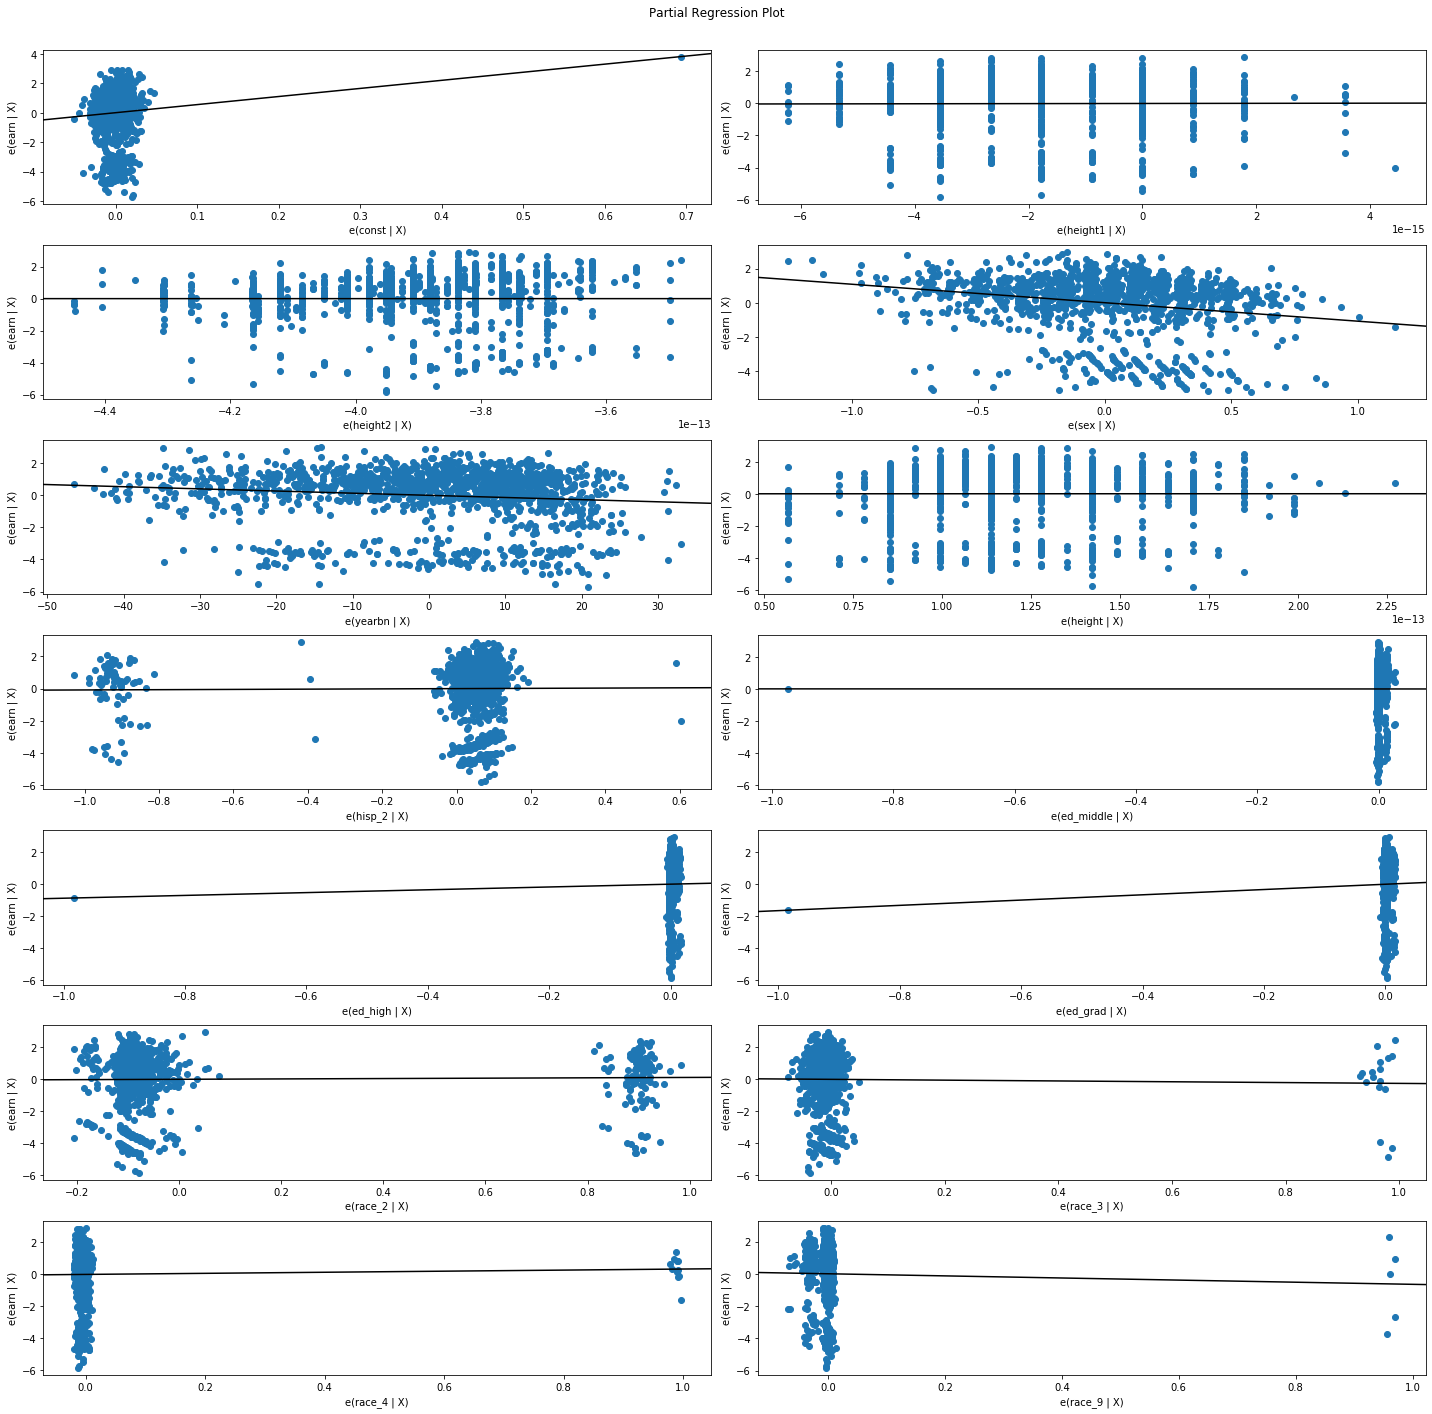

In [12]:
with plt.rc_context():
    plt.rc("figure", figsize=(20,20))
    sm.graphics.plot_partregress_grid(mdl);

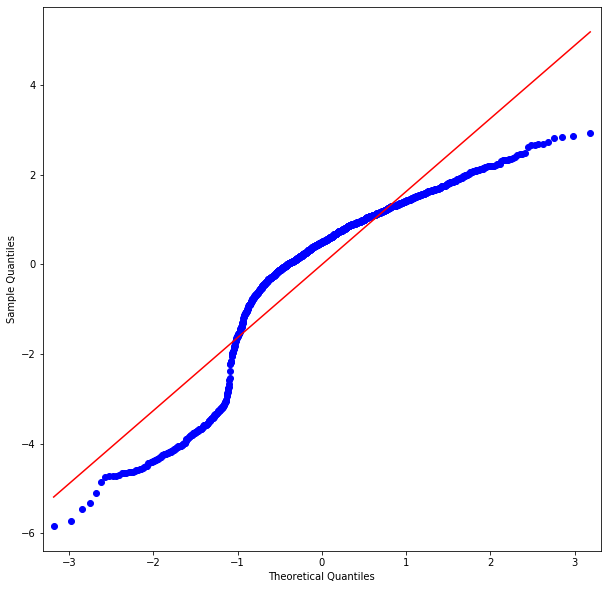

In [14]:
with plt.rc_context():
    plt.rc("figure", figsize=(10,10))
    sm.graphics.qqplot(mdl.resid, line='r')

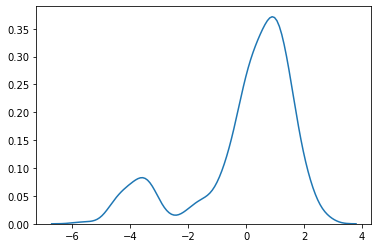

In [15]:
sns.kdeplot(mdl.resid)

Seems to be normal except the left bump, which was caused by the replacement of zeroes.

Overall fit seems fine, $R^2$ is above zero, some variables have expected slope (`yearbn`, `sex` and `education` can be interpreted and follow the expectations)

In [21]:
from itertools import combinations

cols = ['a', 'b', 'c']
[p for q in range(1, len(cols) + 1) for p in combinations(cols, q)]

[('a',), ('b',), ('c',), ('a', 'b'), ('a', 'c'), ('b', 'c'), ('a', 'b', 'c')]

The code I used last time was somehow clumsy and did not finish. Rewrote it in a more straightforward manner. Could be parallelized with joblib if needed.

In [24]:
import statsmodels.formula.api as smf
from itertools import combinations
from tqdm import tqdm

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    exog = set(data.columns)
    exog.remove(response)
    exog_combinations = [p for q in range(1, len(exog) + 1) for p in combinations(exog, q)]
    best_score = 0.0
    best_cols = []
    with tqdm(exog_combinations) as ci:
        for cols in ci:
            formula = "{} ~ {} + 1".format(response, ' + '.join(cols))
            score = smf.ols(formula, data).fit().rsquared_adj
            
            if score > best_score:
                best_score = score
                best_cols = cols
    formula = "{} ~ {} + 1".format(response, ' + '.join(best_cols))
    model = smf.ols(formula, data).fit()
    return model

In [25]:
elim_mdl = forward_selected(earnings_df_concat, "earn")

100%|██████████| 8191/8191 [02:30<00:00, 54.29it/s]


In [26]:
elim_mdl.model.formula

'earn ~ height2 + yearbn + ed_grad + height + ed_high + sex + 1'

In [27]:
elim_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   earn   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     52.36
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           3.16e-58
Time:                        15:45:41   Log-Likelihood:                -2725.6
No. Observations:                1376   AIC:                             5465.
Df Residuals:                    1369   BIC:                             5502.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3892      1.203      4.481      0.000       3.030       7.748
height2        0.0321      0.015      2.081      0.038       0.002       0.062
yearbn        -0.0137      0.003     -4.388      0.000      -0.020      -0.008
ed_grad        1.6682      0.226      7.376      0.000       1.225       2.112
height         0.0454      0.018      2.518      0.012       0.010       0.081
ed_high        0.9027      0.227      3.969      0.000       0.457       1.349
sex           -1.0668      0.138     -7.719      0.000      -1.338      -0.796
==============================================================================
Omnibus:                      254.724   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.754
Skew:                          -1.275   Prob(JB):                     1.74e-89
Kurtosis:                       3.794   Cond. No.                     2.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""